In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow_datasets as tfds 
tfds.load("div2k/bicubic_x4")

{'train': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>,
 'validation': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>}

### 저해상도 이미지의 HR화
- ill-posed(inverse) problem : 다양한 경우의 수 존재

(400, 600, 3)


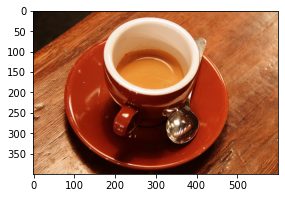

In [3]:
from skimage import data
import matplotlib.pyplot as plt

# data.(blah) can be found in
# https://scikit-image.org/docs/dev/api/skimage.data.html
hr_image = data.coffee() # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

In [4]:
type(hr_image)

numpy.ndarray

`opencv` 라이브러리의 `resize()`함수로 일부러 크기를 줄여 저해상도로 낮춰보겠습니다

(100, 150, 3)


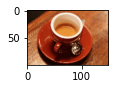

In [5]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(150,100)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)

작아진 커피 이미지로 interpolation 방법을 적용하여 Super Resolution으로 만들기

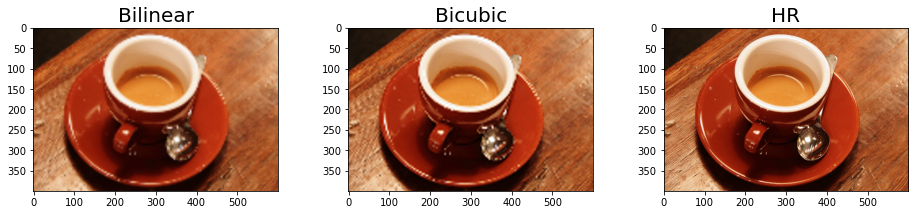

In [6]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=(600, 400), # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(600, 400), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

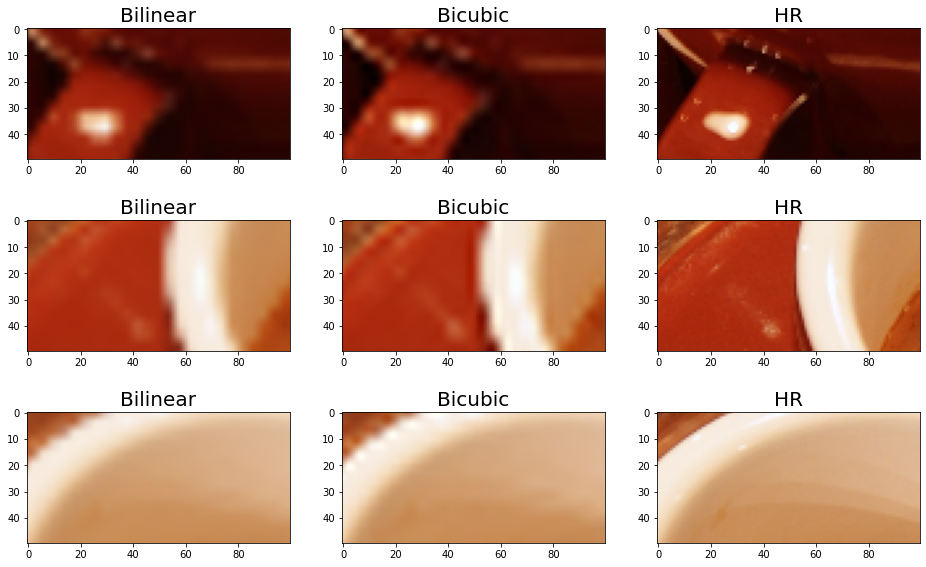

In [7]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

# 19-6. SRCNN

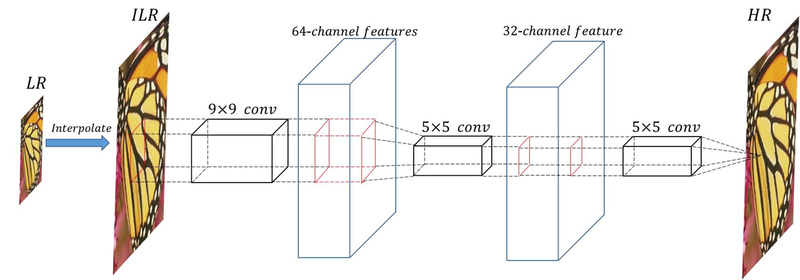

# 19-7. Post SRCNN
---
- VDSR(Very Deep Super Resolution): 20 conv layers + interpolation
- RDN (Residual Dense Network)
- RCAN (Residual Channel Attention Networks)
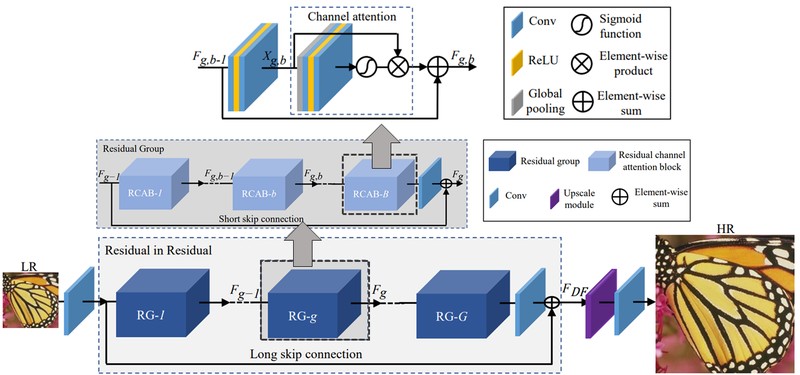

# 19-8. SRCNN을 이용해 SR 도전하기
- `DIV2K` 데이터셋 from `tensorflow-datasets` 라이브러리
- bicubic interpolation

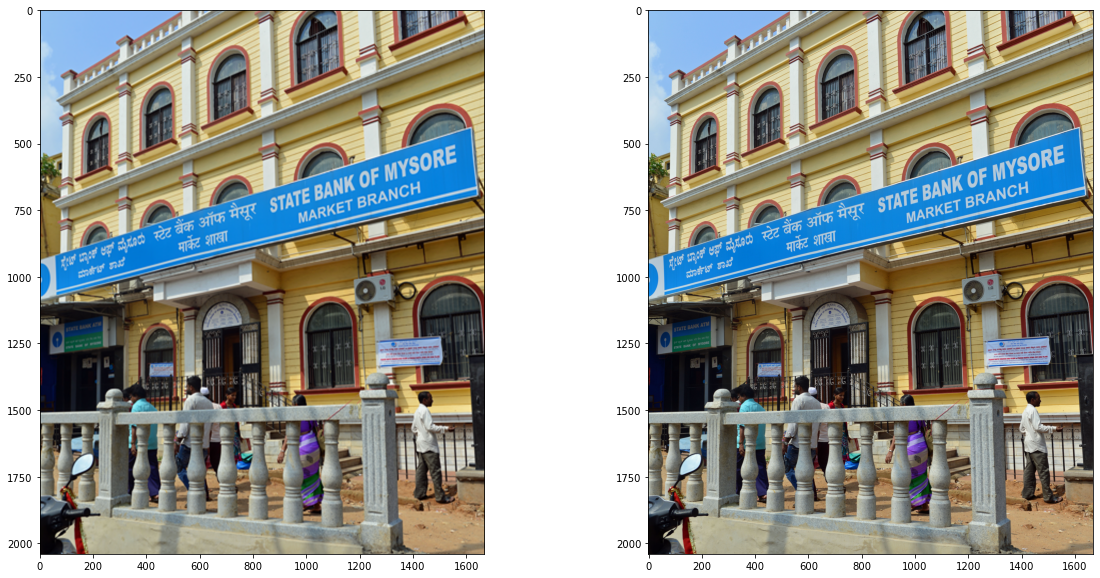

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 데이터를 불러옵니다.
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 0: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화 합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

Text(0.5, 1.0, 'HR')

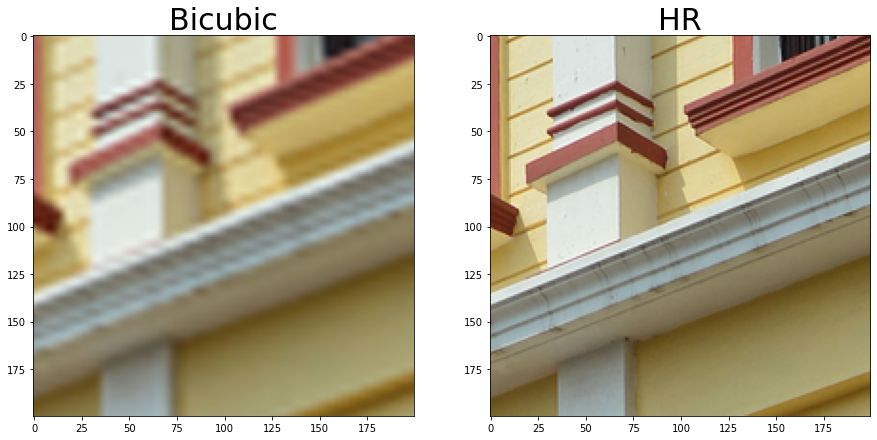

In [9]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

In [10]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)
print("✅")

1 Physical GPUs, 1 Logical GPUs
✅


SRCNN 구현하기

In [11]:
from tensorflow.keras import layers, Sequential

# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   31232     
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


In [12]:
srcnn.compile(
    optimizer="adam", 
    loss="mse"
)

srcnn.fit(train, validation_data=valid, epochs=1)

50/50 [==============================] - 10s 192ms/step - loss: 0.0300 - val_loss: 0.0081


SRCNN 테스트하기

```sh
$ mkdir -p ~/aiffel/super_resolution
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srcnn.h5
$ mv srcnn.h5 ~/aiffel/super_resolution
```

In [13]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/e/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

In [14]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_hr)

3개 이미지(bicubic interpolation의 결과, SRCNN의 결과, 원래 고해상도 이미지)를 나란히 시각화

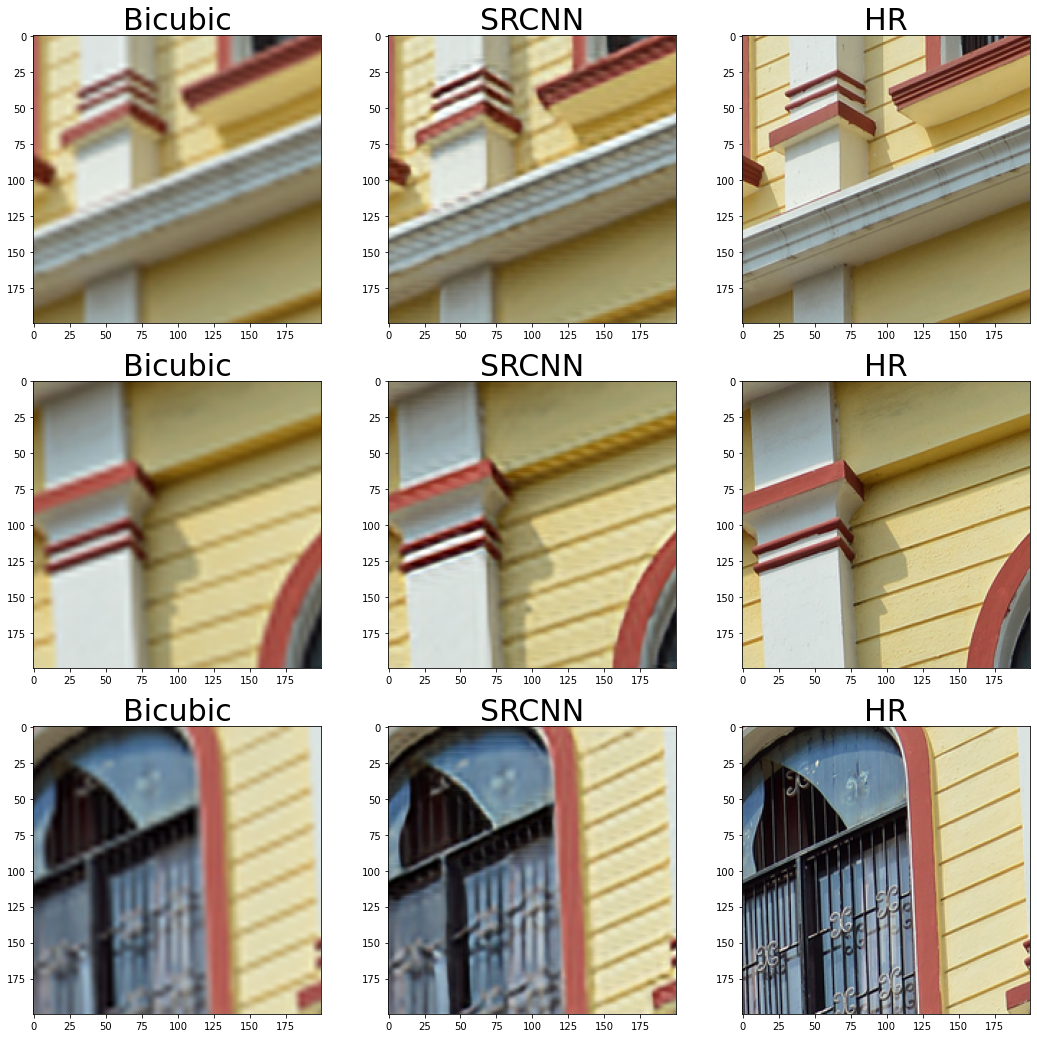

In [15]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

## 19-9. Deep Learning을 이용한 Super Resolution (3) SRGAN

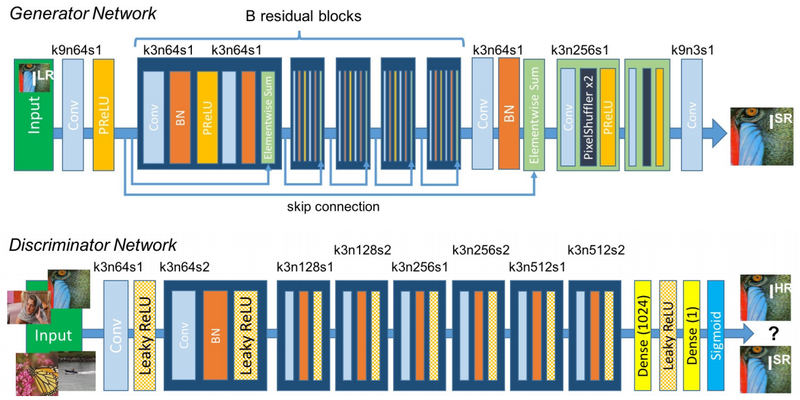


[출처: https://arxiv.org/pdf/1609.04802.pdf]
- content loss와 adversarial loss로 구성
- adversarial loss: 일반적으로 알고 있는 GAN의 loss
- content loss

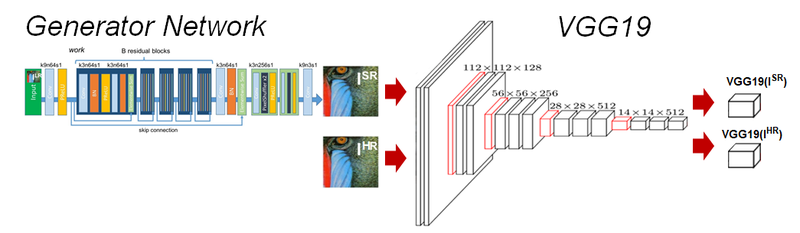

content loss는 Generator를 이용해 얻어낸 (가짜) 고해상도 이미지를 실제 (진짜) 고해상도 이미지와 직접 비교하는 것이 아니라, 각 이미지를 이미지넷으로 사전 학습된(pre-trained) VGG 모델에 입력하여 나오는 feature map에서의 차이를 계산

- SRCNN은 생성해낸 고해상도 이미지를 원래 고해상도 이미지와 직접 비교하여 loss를 계산
- SRGAN에서는 생성된 고해상도 이미지와 실제 고해상도 이미지를 VGG에 입력하여 모델 중간에서 추출해낸 특징을 비교해서 loss를 계산
- VGG를 이용한 content loss 및 GAN을 사용함으로써 발생하는 adversarial loss를 합하여 최종적으로 perceptual loss라고 정의하며 이를 학습에 이용

## 19-10. SRGAN을 이용해 Super Resolution 도전하기

### 데이터 준비하기
---

In [16]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)
print("✅")

✅


### SRGAN 구현하기

__Generator__
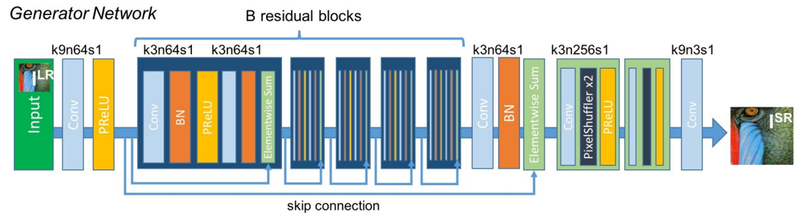

In [17]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


__Discriminator__
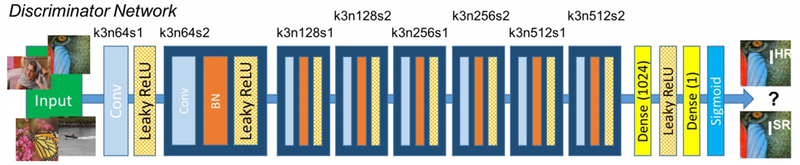

In [18]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


SRGAN은 VGG19를 이용해 content loss를 계산

In [19]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


### SRGAN 학습하기
200 epochs

In [20]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

EPOCH[1] - STEP[10] 
Generator_loss:0.0015 
Discriminator_loss:1.3457

EPOCH[1] - STEP[20] 
Generator_loss:0.0020 
Discriminator_loss:0.8231

EPOCH[1] - STEP[30] 
Generator_loss:0.0019 
Discriminator_loss:0.8944

EPOCH[1] - STEP[40] 
Generator_loss:0.0018 
Discriminator_loss:0.9489

EPOCH[1] - STEP[50] 
Generator_loss:0.0018 
Discriminator_loss:0.9817

EPOCH[1] - STEP[60] 
Generator_loss:0.0018 
Discriminator_loss:0.8982

EPOCH[1] - STEP[70] 
Generator_loss:0.0021 
Discriminator_loss:0.7955

EPOCH[1] - STEP[80] 
Generator_loss:0.0024 
Discriminator_loss:0.7006

EPOCH[1] - STEP[90] 
Generator_loss:0.0027 
Discriminator_loss:0.6270

EPOCH[1] - STEP[100] 
Generator_loss:0.0030 
Discriminator_loss:0.5677

EPOCH[1] - STEP[110] 
Generator_loss:0.0032 
Discriminator_loss:0.5176

EPOCH[1] - STEP[120] 
Generator_loss:0.0035 
Discriminator_loss:0.4764

EPOCH[1] - STEP[130] 
Generator_loss:0.0037 
Discriminator_loss:0.4464

EPOCH[1] - STEP[140] 
Generator_loss:0.0038 
Discriminator_loss:0.4220

E

### SRGAN 테스트하기
---
SRGAN이 만족스러운 결과를 도출할 때까지는 상당히 많은 학습 시간을 요구합니다. 이전과 마찬가지로 이미 학습이 완료된 SRGAN을 미리 준비해 놓았습니다😅 이를 이용해 테스트 해봅시다.
```sh
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5
$ mv srgan_G.h5 ~/aiffel/super_resolution
```

In [21]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/e/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [22]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)
print("✅")

✅


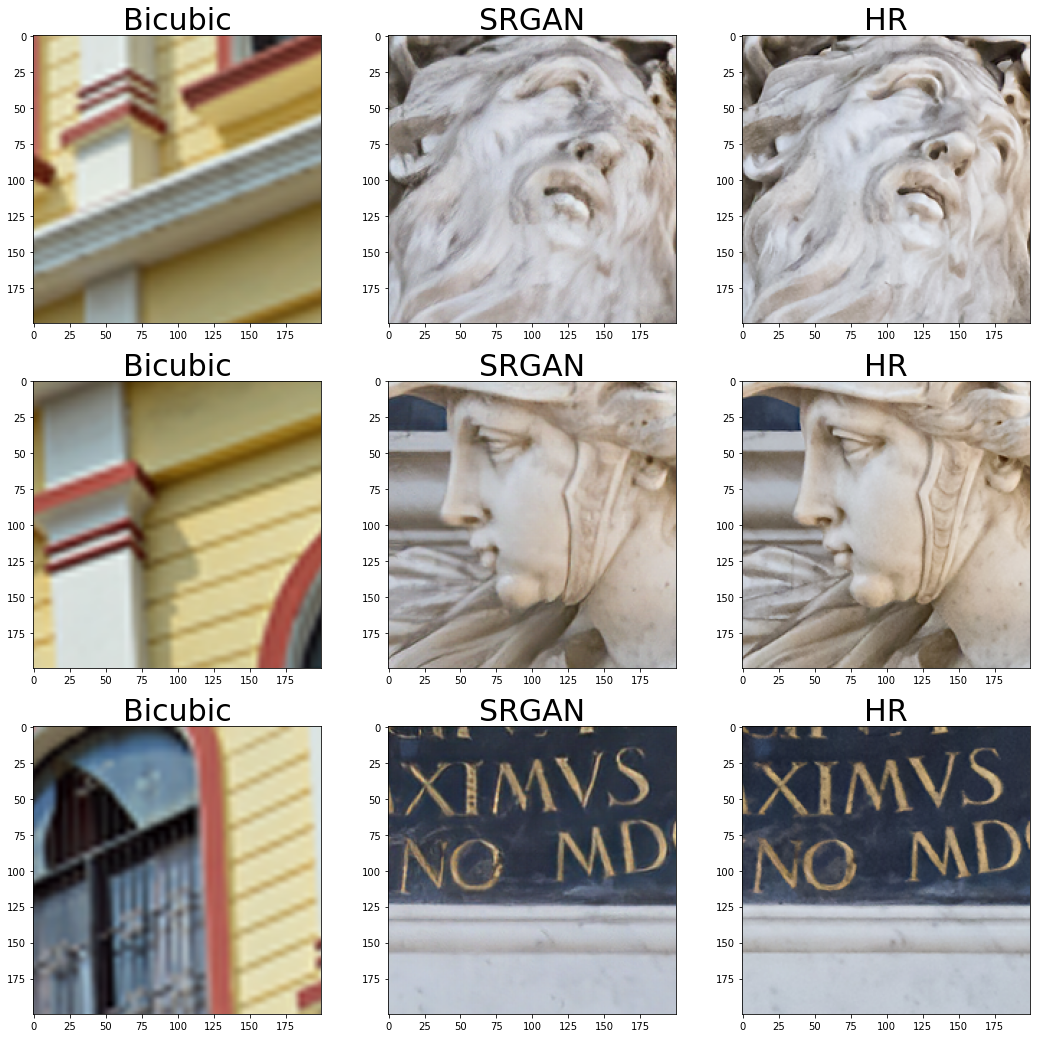

In [23]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

## 19-11. Super Resolution 결과 평가하기
---
SRCNN과 SRGAN 모델 각각이 만들어낸 고해상도 이미지를 비교

- PSNR(Peak Signal-to-Noise Ratio): 영상 내 신호가 가질 수 있는 최대 신호에 대한 잡음(noise)의 비율 (db, 데시벨 단위). 수치가 높을수록 원본 영상에 비해 손실 적음
- SSIM(Structural Similarity Index Map): 영상의 구조 정보를 고려하여 얼마나 구조 정보를 변화시키지 않았는지를 계산. 값이 높을수록 좋음

(400, 600, 3)


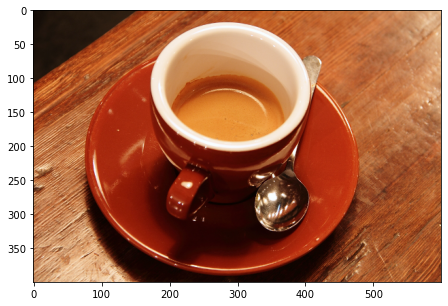

In [24]:
from skimage import data
import matplotlib.pyplot as plt

hr_cat = data.coffee() # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_shape = hr_cat.shape[:2]

print(hr_cat.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(8,5))
plt.imshow(hr_cat)

In [25]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print("**동일 이미지 비교**")
print("PSNR :", peak_signal_noise_ratio(hr_cat, hr_cat))
print("SSIM :", structural_similarity(hr_cat, hr_cat, multichannel=True))

**동일 이미지 비교**
PSNR : inf
SSIM : 1.0


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


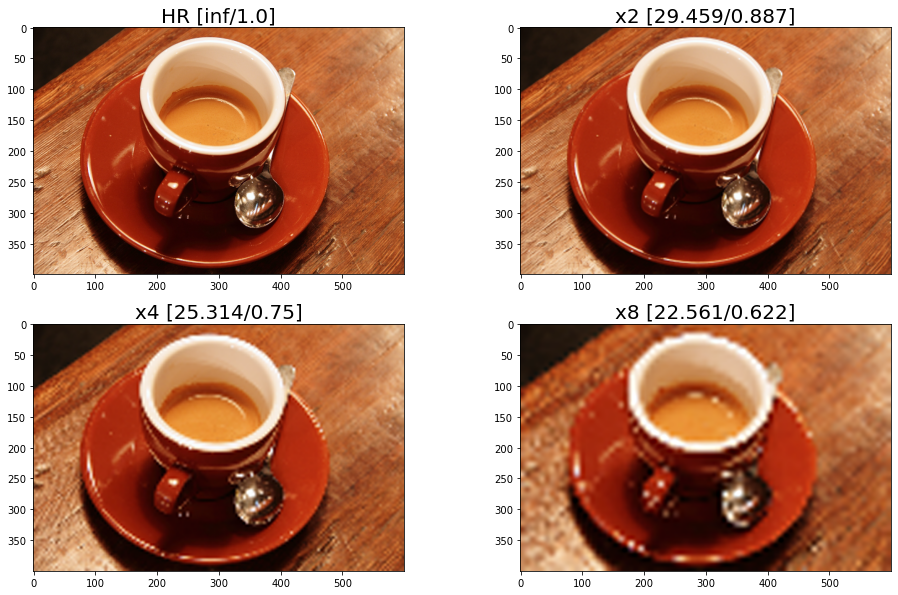

In [26]:
import cv2

# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def interpolation_xn(image, n):
    downsample = cv2.resize(
        image,
        dsize=(hr_shape[1]//n, hr_shape[0]//n)
    )
    upsample = cv2.resize(
        downsample,
        dsize=(hr_shape[1], hr_shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample

lr2_cat = interpolation_xn(hr_cat, 2) # 1/2로 줄이고 다시 복원
lr4_cat = interpolation_xn(hr_cat, 4) # 1/4로 줄이고 다시 복원
lr8_cat = interpolation_xn(hr_cat, 8) # 1/8로 줄이고 다시 복원

images = [hr_cat, lr2_cat, lr4_cat, lr8_cat]
titles = ["HR", "x2", "x4", "x8"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_cat, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_cat, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(16,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)

__해상도를 줄일 수록 그 이미지를 원래 크기로 interploation 했을 때, 각각의 계산 결과가 눈에 띄게 감소하는 것을 알 수 있다__

# 19-12. SRCNN 및 SRGAN 결과 비교하기

잘라내어 확대해보기

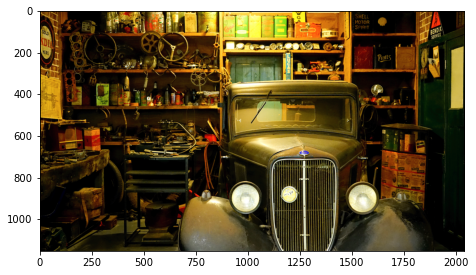

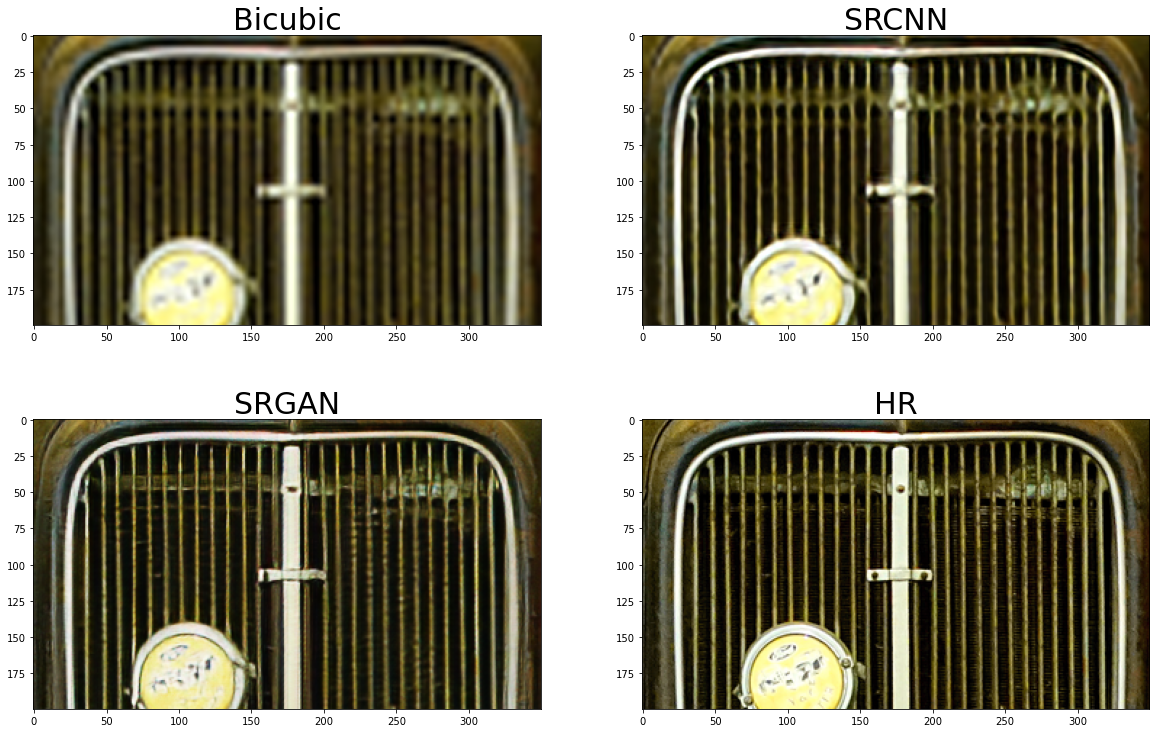

In [27]:
for i, (lr, hr) in enumerate(valid):
    if i == 12: break # 12번째 이미지를 불러옵니다.

lr_img, hr_img = np.array(lr), np.array(hr)

# bicubic interpolation
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

# 전체 이미지를 시각화합니다.
plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

# SRCNN을 이용해 고해상도로 변환합니다.
srcnn_img = apply_srcnn(bicubic_img)

# SRGAN을 이용해 고해상도로 변환합니다.
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (700, 1090) # 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.

# bicubic, SRCNN, SRGAN 을 적용한 이미지와 원래의 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

여러 이미지 동일작업 실행

In [ ]:
for i, (lr, hr) in enumerate(valid):
    if i == 15: break

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (600, 1500)

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

In [ ]:
for i, (lr, hr) in enumerate(valid):
    if i == 8: break

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (900, 1500)

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

In [ ]:
for i, (lr, hr) in enumerate(valid):
    if i == 24: break

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

left_top = (700, 1300)

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

42번

In [ ]:
for i, (lr, hr) in enumerate(valid):
    # 불러올 이미지의 인덱스를 지정합니다.
    # 위에서 시각화 했던 8, 12, 15, 24 번을 제외한 다른 숫자를 넣어봅시다 
    if i == 42 : 
        break          
lr_img, hr_img = np.array(lr), np.array(hr)
print(hr_img.shape)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

# 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (200, 750) 

plt.figure(figsize=(20,20)) # 이미지 크기를 조절할 수 있습니다.
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    # crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

__각 SR 결과와 원래 HR이미지 사이의 PSNR, SSIM 계산해보기__

In [ ]:
for i, (lr, hr) in enumerate(valid):
    if i == 24: break
    
lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img,
    (hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(hr_img, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(hr_img, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(18,13))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

In [ ]:
left_top = (620, 570)
crop_images = [crop(i, left_top, 150, 250) for i in images]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

직접 고른 이미지의 특정 영역에 대해서만 PSNR, SSIM 계산하기

In [ ]:
for i, (lr, hr) in enumerate(valid):
    # 불러올 이미지의 인덱스를 지정합니다.
    # 위에서 시각화 했던 8, 12, 15, 24 번을 제외한 다른 숫자를 넣어봅시다 
    if i == 42 : 
        break          

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img,
    (hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

# 확대할 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (300, 750)

# crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
crop_images = [crop(i, left_top, 150, 250) for i in images] 
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10)) # 이미지 크기를 조절할 수 있습니다.
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
---
이제 여러분이 직접 다른 이미지를 사용해 볼 차례입니다.

앞서 사용했던 DIV2K 데이터셋은 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습되었습니다. 이 데이터셋으로 학습된 SRGAN를 이용해 좋은 결과를 얻기 위해서는 위와 같은 과정이 동일하게 진행되는 것이 좋습니다.

아래와 같이 두 가지 다른 단계를 거쳐서 직접 고른 이미지에 대해 SRGAN을 적용해 봅시다. (모델 학습을 진행하는 건 아닙니다❗) 테스트할 이미지를 고를 때, DIV2K 의 학습 데이터셋과 비슷한 종류의 이미지가 좋습니다. 일반적으로 자연, 동물, 건물 등의 이미지가 학습에 사용되었으며, 이와 달리 애니메이션 등의 이미지는 고해상도로 잘 변환되지 않을 수 있습니다.

특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높습니다. 결과와 상관없이 아래 과정만 잘 수행해봅시다.

### 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 `cv2.resize()`를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화 합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)



이미지 로드 및 np array화: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays 참고(asarray, PIL Image.open())

In [ ]:
from PIL import Image
import cv2

# 1
hr = Image.open('peaks.jpg')
hr = np.array(asarray(hr))
print(hr.shape)

# 2
lr_img = cv2.resize(hr_img, dsize=())

# 3


# 4
bicubic_img = cv2.resize(
    lr_img,
    (hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

# 시각화(lr, hr)
images = []

for i, (lr, hr) in enumerate(valid):
    # 불러올 이미지의 인덱스를 지정합니다.
    # 위에서 시각화 했던 8, 12, 15, 24 번을 제외한 다른 숫자를 넣어봅시다 
    if i == 42 : 
        break          
lr_img, hr_img = np.array(lr), np.array(hr)
print(hr_img.shape)
bicubic_img = cv2.resize(
    lr_img, 
    (hr.shape[1], hr.shape[0]), 
    interpolation=cv2.INTER_CUBIC
)

plt.figure(figsize=(20,15))
plt.subplot(311); plt.imshow(hr_img)

srcnn_img = apply_srcnn(bicubic_img)
srgan_img = apply_srgan(lr_img)

images = [bicubic_img, srcnn_img, srgan_img, hr_img]
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

# 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (200, 750) 

plt.figure(figsize=(20,20)) # 이미지 크기를 조절할 수 있습니다.
for i, pind in enumerate([321, 322, 323, 324]):
    plt.subplot(pind)
    # crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

for i, (lr, hr) in enumerate(valid):
    # 불러올 이미지의 인덱스를 지정합니다.
    # 위에서 시각화 했던 8, 12, 15, 24 번을 제외한 다른 숫자를 넣어봅시다 
    if i == 42 : 
        break          

lr_img, hr_img = np.array(lr), np.array(hr)
bicubic_img = cv2.resize(
    lr_img,
    (hr.shape[1], hr.shape[0]),
    interpolation=cv2.INTER_CUBIC
)

# 확대할 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (300, 750)

# crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
crop_images = [crop(i, left_top, 150, 250) for i in images] 
titles = ["Bicubic", "SRCNN", "SRGAN", "HR"]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(18,10)) # 이미지 크기를 조절할 수 있습니다.
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화 합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)